In [1]:
# Imports
#basics
import numpy as np
import pandas as pd
import scipy 

#misc
import time

#files & data
import json
from google.colab import files

#viz
import matplotlib.pyplot as plt
import seaborn as sns 

#settings
color = sns.color_palette()


In [2]:
# Install kaggle and create directory to store kaggle.json
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
# Check if .kaggle exists in what is printed after running this cell
!ls ~/ -a

.   .bashrc  .config  .ipython	.kaggle  .local  .profile
..  .cache   .gsutil  .jupyter	.keras	 .npm	 .tmux.conf


In [ ]:
#########################################################
#             STEP 1: GET DATASET INTO COLAB            #
#########################################################
# Source: https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235
# Get JSON Kaggle API token by going to: 
# 1. Kaggle Profile
# 2. Go to Accounts tab
# 3. Scroll down to API and "Create new API Token"
# 4. JSON file should be automatically downloaded

In [4]:
# Upload kaggle.json you downloaded in the previous step
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nehadesh","key":"b1ff3516c2e6233953aac308c8a8aab7"}'}

In [5]:
# Store Kaggle API token in colab
!rm -f ~/.kaggle/kaggle.json
!cp kaggle.json ~/.kaggle/

In [6]:
# Kaggle recommends running this to prevent other users of your computer from accessing your credentials
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download Yelp Dataset from Kaggle: 
# Link to dataset: https://www.kaggle.com/yelp-dataset/yelp-dataset
!kaggle datasets download -d yelp-dataset/yelp-dataset
!ls

100% 4.92G/4.92G [01:09<00:00, 89.2MB/s]
100% 4.92G/4.92G [01:09<00:00, 75.8MB/s]
kaggle.json  sample_data  yelp-dataset.zip


In [8]:
# Unzip Yelp Data
!unzip '/content/yelp-dataset.zip' -d '/content/yelp-dataset'

Archive:  /content/yelp-dataset.zip
  inflating: /content/yelp-dataset/Dataset_User_Agreement.pdf  
  inflating: /content/yelp-dataset/yelp_academic_dataset_business.json  
  inflating: /content/yelp-dataset/yelp_academic_dataset_checkin.json  
  inflating: /content/yelp-dataset/yelp_academic_dataset_review.json  
  inflating: /content/yelp-dataset/yelp_academic_dataset_tip.json  
  inflating: /content/yelp-dataset/yelp_academic_dataset_user.json  


In [9]:
# Larger datasets require pyspark
!pip install pyspark

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 46.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=fad12326b0b2e3d64d885271b6e6acad1b03b52f7a44644139604515a5b4a149
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [11]:
spark = SparkSession.builder.appName('yelp_dataset').getOrCreate()

In [12]:
# RAW, UNCLEANED DATA (refer to the other notebook for how to clean, etc. Didn't want to remove anything if y'all needed it)
reviews_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_review.json')
business_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_business.json')
users_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_user.json')
# UNCOMMENT BELOW IF YOU NEED THEM
# tips_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_tip.json')
# checkin_sk = spark.read.json('/content/yelp-dataset/yelp_academic_dataset_checkin.json')

In [13]:
# Get dataset for Atlanta
food_business = business_sk.filter(col('categories').contains('Restaurant'))
atl_food_business = food_business.filter(lower(col("city")) == "atlanta")
atl_food_business = atl_food_business.filter(lower(col("state")) == "ga")

In [14]:
reviews_sk = reviews_sk.withColumn("rating", reviews_sk['stars'].cast("double"))
atl_food_reviews = reviews_sk.join(atl_food_business, "business_id", "inner")

In [15]:
star_counts = atl_food_business.groupBy('stars').count().toPandas()


In [16]:
print(atl_food_business.approxQuantile("stars", [0.5], 0.25)) 

[3.0]


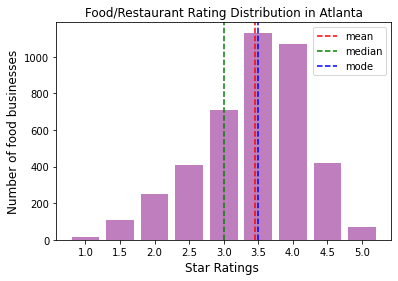

In [17]:
mode = 3.5
mean = 3.45
median = 3.0
#plot
star_counts = star_counts.sort_values(ascending=True, by='stars')
data_labels = [rate for rate in star_counts['stars'].values]
data_points = [count_val for count_val in star_counts['count'].values]

# plt.figure(figsize=(8,6))
y_pos = np.arange(len(data_labels))
plt.bar(data_labels, data_points, align='center', alpha=0.5, color='purple', width=0.4)
plt.xticks(data_labels)
plt.ylabel('Number of food businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)
plt.title("Food/Restaurant Rating Distribution in Atlanta")


line1 = plt.axvline((mean), color='r', linestyle='--')
line2 = plt.axvline((median), color='g', linestyle='--')
line3 = plt.axvline((mode), color='b', linestyle='--')
plt.legend((line1, line2, line3), ('mean', 'median', 'mode'))

plt.show()

In [18]:
review_counts = atl_food_reviews.groupby('user_id').count().toPandas()
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000, 5000]
groups = pd.cut(review_counts['count'], bins)
review_counts_grouped = review_counts.groupby(groups)['count'].agg(['count'])
review_counts_details = review_counts_grouped.rename(columns={'count': 'user_count'})

In [19]:
review_counts_details

,user_count
count,
"(0, 1]",131798
"(1, 2]",33380
"(2, 3]",14380
"(3, 4]",7971
"(4, 5]",4964
"(5, 10]",9845
"(10, 20]",4573
"(20, 50]",2518
"(50, 100]",639


In [20]:
# PRE-PROCESSING: REMOVE USERS WITH <= 5 REVIEWS
high_reviewers = review_counts[review_counts['count'] > 5]['user_id'].values
list_reviewers = set([reviewer for reviewer in high_reviewers])

# Keep reviews by high reviewing users
reviews_final = atl_food_reviews[atl_food_reviews['user_id'].isin(list_reviewers)]
# Remove these users
users_final = users_sk[users_sk['user_id'].isin(list_reviewers)]

In [22]:
#library imports
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import sparse


In [23]:
ratings_df = atl_food_reviews.select('user_id', 'business_id', 'rating')

In [24]:
w = Window().partitionBy().orderBy("business_id")
rest_sk = atl_food_business.withColumn('business_cid', row_number().over(w)-1)
rest_sk.select('business_cid', 'name', 'stars').show(5)

+------------+-------------------+-----+
|business_cid|               name|stars|
+------------+-------------------+-----+
|           0|    Planet Smoothie|  4.5|
|           1|      Burger Theory|  4.0|
|           2|   Big Daddy's Dish|  3.5|
|           3|              Verde|  3.5|
|           4|Marcello's at Emory|  3.5|
+------------+-------------------+-----+
only showing top 5 rows



In [25]:
rest_reviews_sk = atl_food_reviews.join(rest_sk.select('business_id', 'business_cid'), on='business_id', how='inner')


In [26]:
# Unique users extraction
unique_users = atl_food_reviews.select(['user_id']).drop_duplicates()
rest_users_sk = users_sk.join(unique_users, 'user_id', 'inner')
rest_users_sk.count()

210317

In [27]:
w = Window().partitionBy().orderBy("user_id")
rest_users = rest_users_sk.withColumn('user_cid', row_number().over(w) - 1)

In [28]:
w = Window().partitionBy().orderBy("review_id")
rest_reviews = rest_reviews_sk.withColumn('review_cid', row_number().over(w) - 1)
rest_reviews.select('review_cid', 'review_id','business_cid', 'business_id','user_id','rating').show(5)

+----------+--------------------+------------+--------------------+--------------------+------+
|review_cid|           review_id|business_cid|         business_id|             user_id|rating|
+----------+--------------------+------------+--------------------+--------------------+------+
|         0|---7PjSvrmi2bAcAr...|        3028|iG8DnZCnKHH_KYC8p...|O-aq4WiNqyjO9ZgpV...|   5.0|
|         1|---eBVF-WcHtyZaEa...|        3154|kRx08q03nV745mDW8...|PPcZ0IdSgo7dD7Bdo...|   4.0|
|         2|---eMk6r8ot4sLVv0...|        1520|LbwNEFO6NzfZt9SKS...|ZB2x3zxC8W50Ao8-2...|   1.0|
|         3|---glmKKXX8w-tQG6...|         766|A6vrO4KaBkRUWZQKi...|cw7lhK3bZuTWpmNbc...|   2.0|
|         4|---q13BxSrxe57HZy...|          61|-z8D7z4o1VXEJtxJT...|Ueu8Xtg3Zpo9EE3bw...|   5.0|
+----------+--------------------+------------+--------------------+--------------------+------+
only showing top 5 rows



In [29]:
rest_reviews_final = rest_reviews.join(rest_users.select('user_id', 'user_cid'),'user_id','inner')

In [30]:
rating_counts = rest_reviews_final.groupby('user_cid').count().toPandas()
rating_counts.head()

,user_cid,count
0,15790,2
1,45615,3
2,80451,2
3,72758,1
4,95940,1


In [31]:
# PRE-PROCESSING: REMOVE USERS WITH <= 5 REVIEWS
high_reviewers = rating_counts[rating_counts['count'] > 5]['user_cid'].values
list_reviewers = set([int(reviewer) for reviewer in high_reviewers])

# Keep reviews by high reviewing users
rest_reviews_final = rest_reviews_final[rest_reviews_final['user_cid'].isin(list_reviewers)]
# Remove these users

In [32]:
ratings_df = rest_reviews_final.select('review_id', 'review_cid', 'user_cid', 'user_id', 'business_cid', 'business_id', 'rating').toPandas()


In [33]:
ratings_df.to_csv('/content/yelp_data.csv')